In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
import andreap
from scipy.interpolate import interp1d

import importlib.util
import sys

In [2]:
test_index = 0
validation_set = False
# skips comparison with Andrea's code
fast = False

In [20]:
''' This messiness is necessary to import scripts which are not installed and
which are not located in the cwd.'''

spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../cassL/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

spec = importlib.util.spec_from_file_location(
    "generate_emu_data", "../../cassL/generate_emu_data.py")
ged = importlib.util.module_from_spec(spec)
sys.modules["generate_emu_data"] = ged
spec.loader.exec_module(ged)

In [21]:
hc = np.load("hc_G3_redo.npy",
    allow_pickle=True)
samples = np.load("samples_G3_redo.npy",
    allow_pickle=True)

if False:
    hc = np.load("hc_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)
    samples = np.load("samples_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)

if validation_set:
    hc = np.load("hc_test_G3.npy",
        allow_pickle=True)
    samples = np.load("samples_test_G3.npy",
        allow_pickle=True)
    
standard_k = np.load("standard_k.npy", allow_pickle=True)

In [22]:
test_cosmology = hc[test_index]
test_pspec = samples[test_index]

In [23]:
ombh2 = test_cosmology[0]
omch2 = test_cosmology[1]
ns = test_cosmology[2]
sigma12 = test_cosmology[3]
As = test_cosmology[4]
omnuh2 = test_cosmology[5]

In [24]:
full_cosm = ged.build_cosmology(ombh2, omch2, ns, sigma12, As, omnuh2)

In [25]:
mnu = full_cosm['mnu']

In [26]:
# Comprehensive checking function
def get_sigma12_interpolator(ombh2, omch2, ns, mnu, h, As):
    Pk = andreap.get_PK(ombh2, omch2, ns, mnu, h * 100, As, w_mzero=True)
    NUM_Z_POINTS=150
    
    z = np.linspace(0., 9., NUM_Z_POINTS)
    sig12 = np.zeros(NUM_Z_POINTS)
    for i in range(NUM_Z_POINTS):
        sig12[i] = andreap.get_s12(Pk['mzero'], z[i])
    
    return interp1d(sig12, z, kind='cubic')

In [27]:
def validate_results(interpolator, sigma12, best_z):
    interpolator_best_z = None
    try:
        interpolator_best_z = interpolator(sigma12)
    except ValueError:
        print("The desired sigma12 is not attainable with this interpolator!")
        return
    
    print(best_z is None, interpolator_best_z is None)
    
    print("% discrepancy between results for best redshift:",
          (best_z - interpolator_best_z) / interpolator_best_z * 100)


MEMNeC:
ombh2 0.023080185000000003
omch2 0.11757400000000001
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.9719208001518633
omnuh2 0
mnu 0.0

Original cosmology:
ombh2 0.023080185000000003
omch2 0.109367
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.9719208001518633
omnuh2 0.008207
mnu 0.763278082362583


Maximum s12: 0.933928392486508


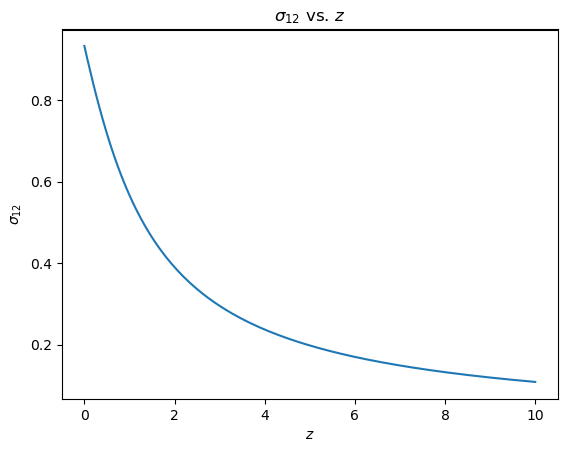

Target sigma12: 0.9719208001518633

MEMNeC:
ombh2 0.023080185000000003
omch2 0.11757400000000001
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.5700000000000001
w0 -1.0
wa 0.00
sigma12 0.9719208001518633
omnuh2 0
mnu 0.0

Original cosmology:
ombh2 0.023080185000000003
omch2 0.109367
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.5700000000000001
w0 -1.0
wa 0.00
sigma12 0.9719208001518633
omnuh2 0.008207
mnu 0.763278082362583


Maximum s12: 1.0040115361127562


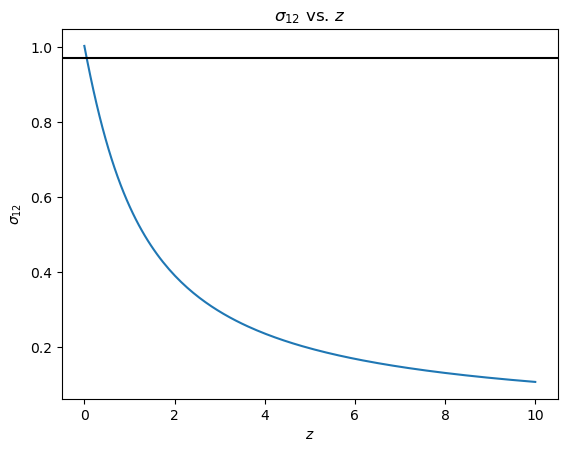

Target sigma12: 0.9719208001518633
recommended redshift 0.05165726166971435
We had to move h to 0.57
This is our approximation 0.9719201815328333


In [28]:
g_pspec, g_sigma12, g_z = ged.evaluate_cell(full_cosm, standard_k, debug=True)
print("This is our approximation", g_sigma12)

In [29]:
s12i_hi_h = get_sigma12_interpolator(
    ombh2, omch2, ns, mnu, .57, As)
    
validate_results(s12i_hi_h, sigma12, g_z)
print()
validate_results(s12i_hi_h, g_sigma12, g_z)

0.008207
1
massive-neutrino sigma12 [0.80262619]
massless-neutrino sigma12 [1.00397832]
False False
% discrepancy between results for best redshift: [1.00457045e+03 1.03657582e-01]

False False
% discrepancy between results for best redshift: [1.00454874e+03 1.01689730e-01]


In [30]:
z_best_andrea = s12i_hi_h(0.971921597558254)
z_best_andrea

array(0.05160246)

In [31]:
import copy as cp
MEMNeC = cp.deepcopy(full_cosm)
MEMNeC['omch2'] += MEMNeC['omnuh2']
MEMNeC = ci.specify_neutrino_mass(MEMNeC, 0, 0)

In [32]:
kci_t, zci_t, pci, sci_t = ci.evaluate_cosmology(MEMNeC, redshifts=[z_best_andrea],
    k_points=300)

In [33]:
(sci_t - g_sigma12) / g_sigma12 * 100

array([0.0034377])

In [34]:
kci, zci, pci, sci = ci.evaluate_cosmology(MEMNeC, redshifts=[z_best_andrea],
    k_points=300)

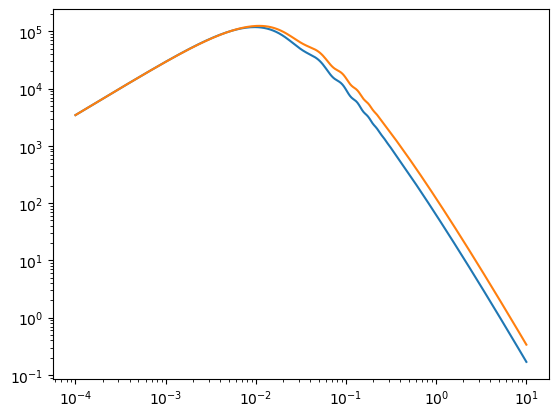

In [35]:
plt.loglog(standard_k, g_pspec, label="ged")
plt.loglog(standard_k, pci, label="Andrea")